# Reading the ROOT files

In [1]:
exec(open("./do_imports.py").read())

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

2.3.0 /home/sophiafarrell/.local/lib/python3.7/site-packages/tensorflow/__init__.py


In [2]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

We want where quicknext<500 us (so another prompt follows) and the subid==1. 

What if we boost our fast-neutron stamps by not requiring it to be the first event (so tri-neutron events recorded too but in pairs?) 
<br>
Obviously this is not realistic since we'd veto these by having 3, but we can at least pretend they're di-neutrons! 

Edit: the next code is already doing that! We gain 1149/5500 of the stats from that trick, which is necessary. 

In [3]:
def get_paired_data(data):
    next_ts = data.timestamp[1:]
    next_ts = ak.concatenate([next_ts, 0])

    condition_1 = next_ts - data.timestamp<600
    condition_2 = next_ts - data.timestamp>0
    condition_3 = data.dt_next_us < 600

    both = condition_1 * condition_2 * condition_3

    first_of_two = ak.where(both)[0]
    signal1 = data[first_of_two]
    signal2 = data[first_of_two+1]
    
    return signal1, signal2

In [4]:
fn0, fn1 = get_paired_data(fastn)
ibd0, ibd1 = get_paired_data(ibd)

### Prep data for model input

In [5]:
selection = [ibd0, fn0]
samples = min([len(i) for i in selection])
# smth = [i[:samples] for i in selection]

npmts = 2330
timetot = 1500 #ns 
tres = 10 # ns 
div_factor = tres 
nbins = int(timetot/tres)


In [6]:
size = samples * len(selection)
y = np.array([]) 

first = np.zeros((size, npmts, nbins), dtype=np.float32)
second = np.zeros_like(first)

data_to_manipulate = [[fn0, fn1], [ibd0, ibd1]]
for d, (signal1, signal2) in enumerate(data_to_manipulate):
    print('set %i of %i'%(d+1, len(data_to_manipulate)))
    
    new_bins1 = ak.values_astype((signal1.hittime-300)/div_factor, np.int32)
    new_bins2 = ak.values_astype((signal2.hittime-300)/div_factor, np.int32)

    for i in range(0, samples):
        first[(d+1)*i, signal1.channel[i], new_bins1[i]]=signal1.pmtcharge[i]
        second[(d+1)*i, signal2.channel[i], new_bins2[i]]=signal2.pmtcharge[i]
    y=np.append(y, d*np.ones(samples))


set 1 of 2
set 2 of 2


In [7]:
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(
    first, second, y,
    test_size=0.25, random_state=43
)

In [8]:
del first, second, data_to_manipulate, new_bins1, new_bins2, 
gc.collect()

348

------

Separate out prompt/delayed IBD and delta-ray/neutron capture fast-neutrons

## Getting data in input form

Need to get those with a 1 for sure as it has a 0, then take those separated by the 0 or 1 

In [29]:
model = load_model('weights/coupled_crnn.h5')

In [10]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2330, 150)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2330, 150)]  0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 2330, 128)    142848      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 2330, 128)    142848      input_2[0][0]                    
_______________________________________________________________________________________

In [30]:
scores = model.predict([X_test1, X_test2], verbose=1)
rnn_out_test = scores
np.savetxt("testpreds.csv", scores, delimiter=",")

89/89 [==============================] - 164s 2s/step


In [39]:
from tqdm import tqdm

In [48]:
rnn_out_train = np.zeros((len(X_train1), 2))
for i in tqdm(range(len(rnn_out_train))):
    if i%200==0:
        rnn_out_train[i:i+200] = model.predict([X_train1[i:i+200], X_train2[i:i+200]])


  0%|          | 0/8539 [00:00<?, ?it/s]Exception ignored in: <function tqdm.__del__ at 0x7f6f307f5dd0>
Traceback (most recent call last):
  File "/home/sophiafarrell/.conda/envs/sjf37/lib/python3.7/site-packages/tqdm/std.py", line 1152, in __del__
    self.close()
  File "/home/sophiafarrell/.conda/envs/sjf37/lib/python3.7/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'

100%|██████████| 8539/8539 [08:06<00:00, 17.55it/s]


In [49]:
np.savetxt("trainpreds.csv", rnn_out_train, delimiter=",")

In [50]:
if scores.shape[1]>1:
    y_pred_2 = np.argmax(scores, axis=1)
    y_test_2 = np.argmax(y_test, axis=1)
else:
    y_pred_2, y_test_2 = np.round(scores), y_test

In [ ]:
def draw_confmat(classes=3, 
                 y_test_2=y_test_2, 
                 y_pred_2=y_pred_2, 
                 scores=scores):
    confmat = confusion_matrix(y_test_2, y_pred_2)
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(confmat, annot=True, fmt='g', 
                    )

    ax.set_title('Confusion Matrix fast-n vs. ibd')
    ax.set_xlabel('Predicted PID')
    ax.set_ylabel('Actual PID')

    if classes==2: labels = ['fastn', 'ibd']
    elif classes==3: labels=['fastn', 'ibd0', 'ibd1']
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    plt.show()
    
def draw_roc(classes=3, y_test_2=y_test_2, scores=scores):
    if classes==3: 
        cat1 = [0, 0, 1]
        cat2 = [1, 2, 2]
        labels = ['fastn/ibd0', 'fastn/ibd1', 'ibd0/ibd1',]
    elif classes==2:
        cat1 = [0]
        cat2 = [1]
        labels = ['fast-n/ibd']
        
    plt.figure(figsize=(6,4))
    for i, j, label in zip(cat1, cat2, 
                            labels,
                             ):
        mask = [any(t) for t in zip(y_test_2==i, y_test_2==j)]
        
        if scores.shape[1]>1: prob = scores[:, j][mask]
        else: prob = scores[mask]
        guesses = y_test_2[mask]
        guesses = guesses - np.min(guesses)
        guesses = guesses/np.max(guesses)

        fpr, tpr, thresholds = roc_curve(guesses, prob)

        auc = roc_auc_score(y_test_2[mask], prob)
        plt.plot(fpr, tpr, 
             label='%s (AUC = %0.3f)'%(label, auc), 
    #          color='darkorange', 
             lw=2, 
            )
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RNN ROC: Fast-neutron vs. ibd')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend()
    plt.grid()
    plt.show()    

In [ ]:
draw_confmat(classes=2)

In [ ]:
draw_roc(classes=2)

In [51]:
del model
gc.collect()

6394

In [152]:
rfpred = clf.predict_proba(new_train)[:,1]
rnnpred = rnn_out_train[:,1]

In [74]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [153]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

In [154]:
X = np.vstack([rfpred, rnnpred]).T
bdt.fit(X, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200)

In [155]:
rfpredtest = clf.predict_proba(new_test)[:,1].reshape(len(new_test),1)
rnnpredtest = rnn_out_test

In [156]:
Xtest = np.hstack([rfpredtest, rnnpredtest])
bdt.score(Xtest, y_test)

0.9237794169301019

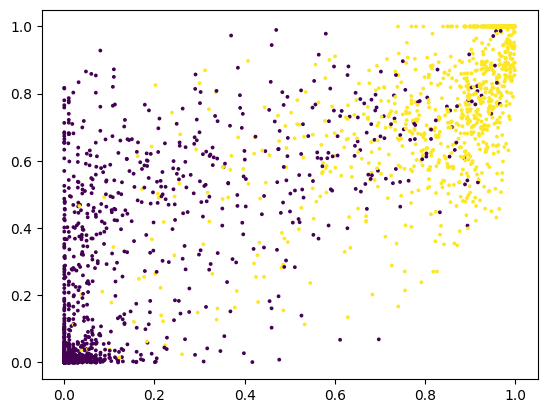

In [158]:
x_min, x_max = 0, 1
# y_min, y_max = 0, 1
# plot_step = 0.02
# xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
#                      np.arange(y_min, y_max, plot_step))

# Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)
# cs = plt.contourf(xx, yy, Z, 
#                   cmap=plt.cm.plasma, alpha=0.2
#                  )
# plt.axis("tight")

plt.scatter(rfpredtest, rnnpredtest, c=y_test, cmap=plt.cm.viridis, s=3)
plt.show()

## Take RNN output and add to X1 (RF) data

In [112]:
dimensions = [
    'n9', 'n100', 
#     'x', 'y', 'z', 
    'r',
    'id_plus_dr_hit', 
#     'good_dir', 
#     'good_dir_next', 
#     'good_pos',
#     'good_pos_next', 
#     'distpmt', 
    'closestPMT', 'closestPMT_next', 
    'drNextr', # 'dzNextz', 
#      'dt_next_us', 
#     'azimuth_ks', 
#     'azimuth_ks_next',
#     'n100_next','n9_next',
    'pe', 
    'beta_one', 
#     'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
#     'beta_one_prev', 'beta_two_prev', 'beta_three_prev', 'beta_four_prev', 'beta_five_prev', 'beta_six_prev',
]
def get_dims(data, dimensions=dimensions):
    df_cut = data[dimensions]
    print('Remaining variables selected for analysis: %i'%(len(dimensions)))
    return df_cut

In [113]:
data_to_manipulate = [fn0, ibd0]
samples = min([len(i) for i in data_to_manipulate])

x1 = data_to_manipulate[0][:samples]
x1 = ak.concatenate((x1, data_to_manipulate[1][:samples]))

X1 = get_dims(x1, dimensions=dimensions)
X1 = ak.to_pandas(X1)

X_train3, X_test3, y_train, y_test= train_test_split(X1, y, test_size=0.25, random_state=43) 
X_save = X_test3
sc = StandardScaler()
X_train3 = sc.fit_transform(X_train3)
X_test3 = sc.transform(X_test3)

Remaining variables selected for analysis: 9


In [114]:
# rnn_out_train = np.zeros((len(y_train),1))
# rnn_out_test = np.zeros((len(y_test),1))

In [134]:
def rnn_to_rf(classes=3, y_train=y_train, y_test=y_test):
    if classes==2: 
        yy_train, yy_test = y_train, y_test
    if classes>2:
        yy_train = np.argmax(y_train, axis=1)
        yy_test = np.argmax(y_test, axis=1)

    new_train = np.hstack((X_train3, rnn_out_train[:,0].reshape(len(rnn_out_train),1)))
#     new_train = np.hstack((X_train3, rnn_out_train))
    new_test = np.hstack((X_test3, rnn_out_test))
    
#     new_train, new_test = X_train3, X_test3
    return new_train, new_test, yy_train, yy_test

In [141]:
classes=2
if classes==2: newdims = ['rnn_out']
elif classes==3: newdims = ['rnn_out_fn', 'rnn_out_ibd0', 'rnn_out_ibd1']

dims_add = dimensions.copy()
for i in newdims:
    dims_add.append(i)

In [136]:
new_train, new_test, yy_train, yy_test = rnn_to_rf(classes=2)

In [137]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(
    n_estimators=100, 
    max_depth=12, 
#     min_samples_leaf=2,
    bootstrap=True,
)
#Train the model using the training sets
clf.fit(new_train,yy_train)

RandomForestClassifier(max_depth=12)

In [138]:
y_train_pred = clf.predict(new_train)
y_test_pred=clf.predict(new_test)

In [139]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(yy_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(yy_test, y_test_pred)*100))

Train Accuracy: 98.76%
Test Accuracy: 92.52%


In [143]:
feature_imp = pd.Series(clf.feature_importances_,index=dims_add).sort_values(ascending=False)

In [144]:
scores = clf.predict_proba(new_test)

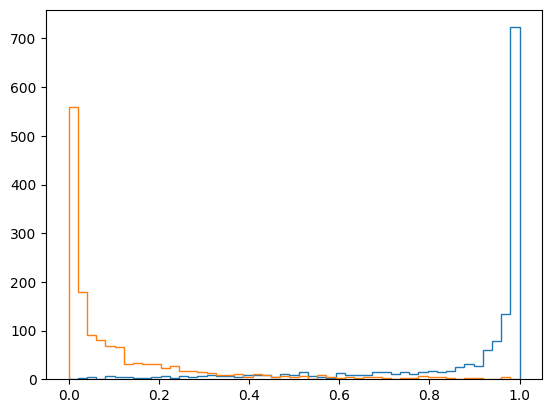

In [145]:
y_test0 = yy_test==0
y_test1 = yy_test==1
kw = dict(bins=np.linspace(0,1,50), histtype='step')
plt.hist(scores[y_test0,0], **kw)
plt.hist(scores[y_test1,0], **kw)
plt.show()

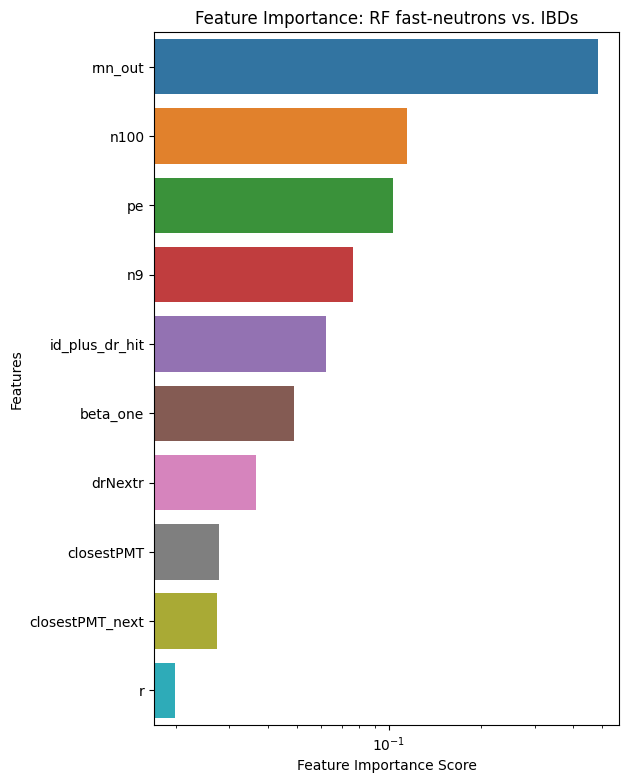

In [146]:
# Creating a bar plot
plt.figure(figsize=(6, 9))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF fast-neutrons vs. IBDs")
# plt.legend()
plt.show()

In [160]:
def draw_confmat(classes=3, 
                 y_test_2=yy_test, 
                 y_pred_2=y_test_pred, 
                 scores=scores,
                **kwargs):
    confmat = confusion_matrix(y_test_2, y_pred_2)
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(confmat, annot=True, fmt='g', 
                    )

    ax.set_title('Confusion Matrix fast-n vs. ibd')
    ax.set_xlabel('Predicted PID')
    ax.set_ylabel('Actual PID')

    if classes==2: labels = ['fastn', 'ibd']
    elif classes==3: labels=['fastn', 'ibd0', 'ibd1']
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    plt.show()
    
def draw_roc(classes=3, y_test_2=yy_test, scores=scores):
    if classes==3: 
        cat1 = [0, 0, 1]
        cat2 = [1, 2, 2]
        labels = ['fastn/ibd0', 'fastn/ibd1', 'ibd0/ibd1',]
    elif classes==2:
        cat1 = [0]
        cat2 = [1]
        labels = ['fast-n/ibd']
        
    plt.figure(figsize=(6,4))
    for i, j, label in zip(cat1, cat2, 
                            labels,
                             ):
        mask = [any(t) for t in zip(y_test_2==i, y_test_2==j)]
        
        if scores.shape[1]>1: prob = scores[:, j][mask]
        else: prob = scores[mask]
        guesses = y_test_2[mask]
        guesses = guesses - np.min(guesses)
        guesses = guesses/np.max(guesses)

        fpr, tpr, thresholds = roc_curve(guesses, prob)

        auc = roc_auc_score(y_test_2[mask], prob)
        plt.plot(fpr, tpr, 
             label='%s (AUC = %0.3f)'%(label, auc), 
    #          color='darkorange', 
             lw=2, 
            )
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('NN into RF ROC: fast-n vs. ibd')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend()
    plt.grid()
    plt.show()    
    
    return fpr, tpr, thresholds

In [148]:
if scores.shape[1]>1:
    y_pred_2 = np.argmax(scores, axis=1)
    try: y_test_2 = np.argmax(y_test, axis=1)
    except: y_test_2=y_test
else:
    y_pred_2, y_test_2 = np.round(scores), y_test

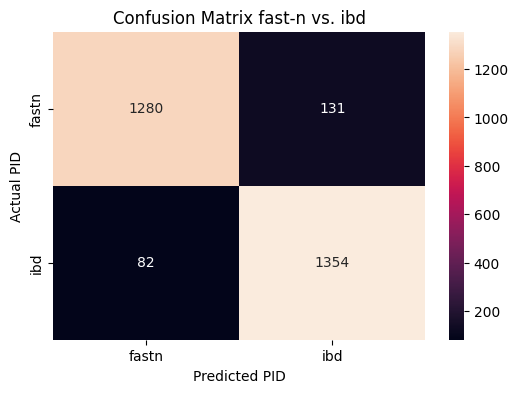

In [149]:
draw_confmat(classes=2, y_test_2=y_test_2, y_pred_2=y_pred_2)

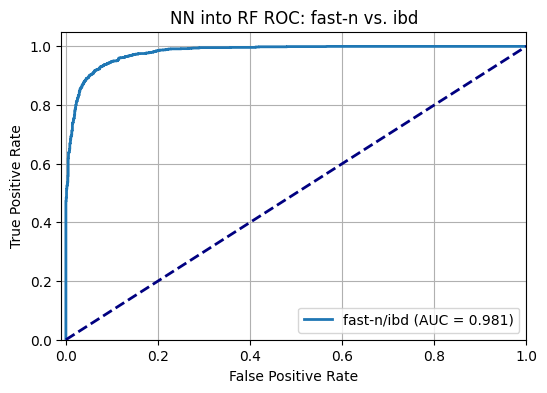

In [161]:
results = draw_roc(2, yy_test, scores)

In [151]:
preds = y_pred_2.reshape(len(y_pred_2))
error_inds = np.argwhere(y_test_2!=preds)
error_inds = error_inds.reshape(len(error_inds))

In [224]:
true_label = y_test_2[error_inds]

In [225]:
wrong_data = X_save.iloc[error_inds]
wrongibd = wrong_data[true_label==1]
wrongfn = wrong_data[true_label==0]

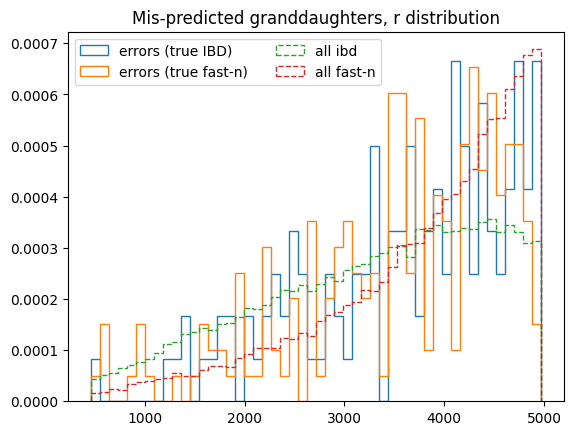

In [226]:
kw = dict(histtype='step', density=True)
key = 'r'
bins= plt.hist(wrongibd[key], bins=50, label='errors (true IBD)', **kw)
plt.hist(wrongfn[key], bins=bins[1], label='errors (true fast-n)', **kw)
plt.hist(ibd[key], bins=bins[1], label='all ibd', linestyle='--', **kw)
plt.hist(fastn[key], bins=bins[1], label='all fast-n', linestyle='--', **kw)

plt.title('Mis-predicted granddaughters, %s distribution'%(key))
plt.legend(loc='upper left', ncol=2)
plt.show()